In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units 
from metpy.interpolate import cross_section
from scipy import signal
from diagnosticSGfunctions import gkern as create_gaussian_kernel

import matplotlib
%matplotlib inline

### Define some bounds for our calculations

- Double check the height of the analysis level 
- Read in PV separately (5.5 to 9.0º rather than 5.5 to 7.0º)

In [20]:
lon_start = 95.0 # 104.0
lon_end = 125.0 # 115.0
lat_start = 0.0 # 5.5
lat_end = 15.0 # 7.0 

height_level = 7000 # previously 5000

### Read in data at 12Z on 23 October 2018 (T+48)

In [22]:
time = int(48)-12
gl_pe='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe{0:03d}.nc'.format(time)
gl_pc='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pc{0:03d}.nc'.format(time)
gl_pb='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pb{0:03d}.nc'.format(time)

input_data_pe = xr.open_dataset(gl_pe).metpy.assign_crs(grid_mapping_name='latitude_longitude', 
                                                        earth_radius=6371229.0)
input_data_pc = xr.open_dataset(gl_pc, drop_variables=['unspecified_5','unspecified_6',   # heating rate 
                                                       'unspecified_9','unspecified_10'])
input_data_pc = input_data_pc.metpy.assign_crs(grid_mapping_name='latitude_longitude', 
                                               earth_radius=6371229.0)
input_data_pb = xr.open_dataset(gl_pb).metpy.assign_crs(grid_mapping_name='latitude_longitude', 
                                                        earth_radius=6371229.0)

### Focus on specified latitude-longitude slice

In [23]:
gdata_pe=input_data_pe.sel(longitude=slice(lon_start, lon_end), latitude=slice(lat_start, lat_end),
                                 longitude_1=slice(lon_start, lon_end), latitude_1=slice(lat_start, lat_end) )
gdata_pb=input_data_pb.sel(longitude=slice(lon_start, lon_end), latitude=slice(lat_start, lat_end) )
gdata_pc=input_data_pc.sel(longitude=slice(lon_start, lon_end), latitude=slice(lat_start, lat_end) )

### Calculate sum of terms contributing to diabatic heating rate (convection, radiation, friction, etc)

In [24]:
heating_rate = 0
vars_list = ['unspecified', 'unspecified_1', 'unspecified_2', 'unspecified_3',
             'unspecified_4', 'unspecified_7','unspecified_8']
for var in vars_list:
    heating_rate = heating_rate + gdata_pc[var]

### Tidy data and interpolate to reference set of vertical levels

In [25]:
ht_coords = gdata_pe.u['hybrid_ht_1'].data.astype('int32')

u_gl = gdata_pe.u.interp(longitude_1=gdata_pe.v["longitude"],
                         hybrid_ht_1=ht_coords,
                         method="linear").assign_coords(height_levels=("hybrid_ht_1",
                        ht_coords)).swap_dims({"hybrid_ht_1":
                        "height_levels"})
v_gl = gdata_pe.v.interp(latitude_1=gdata_pe.u["latitude"],
                         hybrid_ht_1=ht_coords,
                         method="linear").assign_coords(height_levels=("hybrid_ht_1",
                        ht_coords)).swap_dims({"hybrid_ht_1":
                                               "height_levels"})
pv_gl = gdata_pe.field83.interp(hybrid_ht=ht_coords,
                                method="linear").assign_coords(height_levels=("hybrid_ht",
                                ht_coords)).swap_dims({"hybrid_ht":
                                                       "height_levels"})
w_gl  = gdata_pe.dz_dt.interp(hybrid_ht=ht_coords,
                              method="linear").assign_coords(height_levels=("hybrid_ht",
                            ht_coords)).swap_dims({"hybrid_ht":
                                                   "height_levels"})

q_gl  = gdata_pb.q.interp(hybrid_ht=ht_coords,
                          method="linear").assign_coords(height_levels=("hybrid_ht",
                            ht_coords)).swap_dims({"hybrid_ht":
                                                   "height_levels"})
th_gl = gdata_pb.theta.interp(hybrid_ht=ht_coords,
                              method="linear").assign_coords(height_levels=("hybrid_ht",
                            ht_coords)).swap_dims({"hybrid_ht":
                                                   "height_levels"})
rho_gl = gdata_pb.field27.interp(hybrid_ht_1=ht_coords,
                                 method="linear").assign_coords(height_levels=("hybrid_ht_1",
                                ht_coords)).swap_dims({"hybrid_ht_1":"height_levels"})
heating_rate = heating_rate.interp(hybrid_ht=ht_coords,
                                   method="linear").assign_coords(height_levels=("hybrid_ht",
                                ht_coords)).swap_dims({"hybrid_ht":"height_levels"})
exner_func = gdata_pb.field7.interp(hybrid_ht_1=ht_coords,
                                 method="linear").assign_coords(height_levels=("hybrid_ht_1",
                                ht_coords)).swap_dims({"hybrid_ht_1":"height_levels"})

### Reduce the variable dimensions from 3D to 2D

In [26]:
u_gl = u_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
v_gl = v_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
w_gl = w_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

th_gl = th_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
q_gl = q_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
rho_gl = rho_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
pv_gl = pv_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end)) # * 1000000.

vort_gl = mpcalc.vorticity(u_gl, v_gl, dx=None, dy=None)
abs_vort_gl = mpcalc.absolute_vorticity(u_gl, v_gl, dx=None, dy=None)

vort_gl = vort_gl.sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
abs_vort_gl = abs_vort_gl.sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
heating_rate = heating_rate.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end)) / 3600.
exner_func = exner_func.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

## Calculate Ertel PV

In [27]:
latitude = th_gl.latitude * (np.pi / 180.)
f0 = 1.4584E-4 * np.sin(latitude)
# d_heating_rate_dz = mpcalc.first_derivative(heating_rate, axis=0)
d_theta_dz = mpcalc.first_derivative(th_gl, axis=0)

background_ertel_pv = (1 / rho_gl) * f0 * d_theta_dz
ertel_pv = pv_gl

## Upper wave phase speed calculation

### Calculate first term in Eq. 6 (absolute vorticity)

In [28]:
rho_upper = rho_gl.sel(height_levels=slice(8000,10000)).mean(dim=['height_levels'])
rho_lower = rho_gl.sel(height_levels=slice(2000,4000)).mean(dim=['height_levels'])
rho_ave = ( (rho_upper + rho_lower) / 2).mean() 

q_ave = q_gl.sel(height_levels=height_level, method="nearest").mean()
abs_vort = abs_vort_gl.sel(height_levels=height_level, method="nearest").mean()

th_upper = th_gl.sel(height_levels=slice(8000,10000)).mean(dim=['height_levels'])
th_lower = th_gl.sel(height_levels=slice(2000,4000)).mean(dim=['height_levels'])
d_theta  = (th_upper - th_lower).mean()
th_ref   = 300.0
dz       = 6000.0

# term_1 = (9.81 * d_theta / (rho_ave * q_ave * th_ref * dz) )
term_1 = (abs_vort * d_theta / (rho_ave * dz) ) # Current value = 3.52 x 10-7
# term_1 = (f0.mean() * d_theta / (rho_ave * dz) ) # Updated value = 1.10 x 10-7

### Calculate second term in Eq. 6 (moist stability)

In [29]:
term_1

<xarray.DataArray ()>
<Quantity(1.42711255e-07, '1 / second')>
Coordinates:
    t              datetime64[ns] 2018-10-23T12:00:00
    metpy_crs      object Projection: latitude_longitude
    hybrid_ht_1    int32 7036
    height_levels  int32 7036

In [30]:
# calculate moist stability
th_dz = mpcalc.first_derivative(th_gl, axis=0)
th_dz = th_dz * (9.81 / th_ref)
moist_stability = q_gl * th_dz

moist_stability_upper = moist_stability.sel(height_levels=slice(8000,
                            10000)).mean(dim=['height_levels']).mean()
moist_stability_lower = moist_stability.sel(height_levels=slice(2000,
                            4000)).mean(dim=['height_levels']).mean()
moist_stability_interface = moist_stability.sel(height_levels=height_level, method='nearest').mean()

term_2 = (moist_stability_upper - moist_stability_lower) / moist_stability_interface # Current value = -2.49

moist_stratification_factor = term_1 * term_2 # Current value = -8.77 x 10-7

### Set up Gaussian kernel to smooth the datasets for the wave phase speed calculations

In [31]:
kernel_2d = create_gaussian_kernel(3, 1.0)

### Calculate third term in Eq. 6 (diabatic heating)

In [32]:
exner_func_6km = exner_func.sel(height_levels=height_level, method="nearest").mean()
heating_rate_6km = (heating_rate.sel(height_levels=height_level, method="nearest"))

# new method to calculate amplitude (smooth field, and calculate standard deviation)
heating_rate_smoothed = xr.DataArray(signal.convolve2d(heating_rate_6km, kernel_2d, boundary='symm', mode='same'))
heating_rate_mean = heating_rate_smoothed.mean()
heating_rate_std = (heating_rate_smoothed - heating_rate_mean).std()
heating_rate_amplitude = (heating_rate_6km.max() - heating_rate_6km.min()) / 2

# ertel PV (new)
ertel_pv_6km = ertel_pv.sel(height_levels=height_level, method='nearest')
ertel_pv_smoothed = xr.DataArray(signal.convolve2d(ertel_pv_6km, kernel_2d, boundary='symm', mode='same'))
ertel_pv_mean = ertel_pv_smoothed.mean()
ertel_pv_std = (ertel_pv_smoothed - ertel_pv_mean).std()
ertel_pv_amplitude = (ertel_pv_6km.max() - ertel_pv_6km.min()) / 2

pv_wave_length = 8.0 * 111000 
pv_wave_number = (2 * np.pi) / pv_wave_length

term_3a = 1 / pv_wave_number
term_3b = heating_rate_std / d_theta 

term_3c = 1 / ertel_pv_std

term_3 = (term_3a * term_3b * term_3c).mean()

upper_wave_phase_speed = moist_stratification_factor * term_3

## Calculate additional term estimating the impact of basic-state PV gradients

- Double check the height at which we're calculating this term (should be 7 km)
- Double check that the extent of the x-y coordinates are correct too (should be 5.5 to 9.0º N)
- Double check the units in all calculations (especially PV)

### Magnitude of the full balanced v-wind from the SGT tool 

In [33]:
v_gl_upper = (v_gl.sel(height_levels=height_level, method="nearest"))

v_gl_smoothed = xr.DataArray(signal.convolve2d(v_gl_upper, kernel_2d, boundary='symm', mode='same'))
v_gl_mean = v_gl_smoothed.mean()
v_gl_std = (v_gl_smoothed - v_gl_mean).std()
v_gl_amplitude = (v_gl_upper.max() - v_gl_upper.min()) / 2

In [34]:
v_gl_amplitude

<xarray.DataArray 'v' ()>
array(7.59718253)
Coordinates:
    t              datetime64[ns] 2018-10-23T12:00:00
    metpy_crs      object Projection: latitude_longitude
    hybrid_ht_1    int32 7036
    height_levels  int32 7036

### Plot PV field 

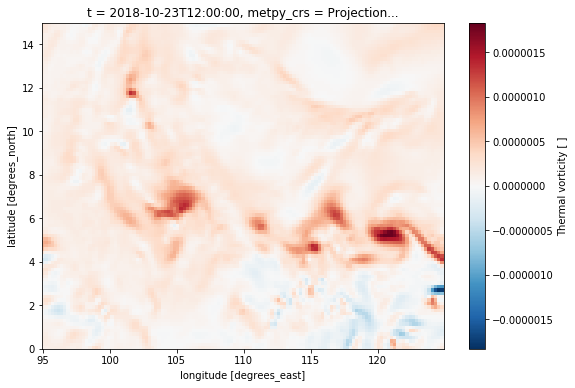

In [35]:
ertel_pv_6km.plot(figsize=(9,6))

### Plot smoothed PV field

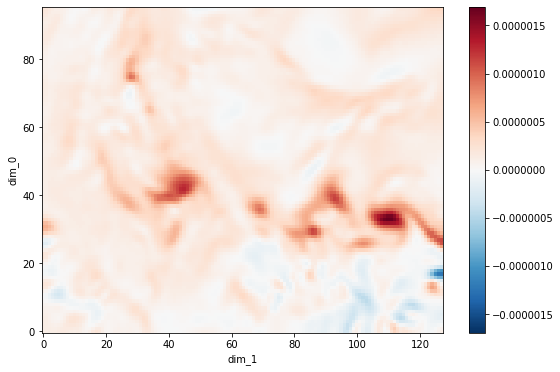

In [36]:
ertel_pv_smoothed.plot(figsize=(9,6))

### Meridional gradient of (smoothed) PV

In [17]:
gdata_pe_pv = input_data_pe.sel(longitude=slice(104.0, 115.0), latitude=slice(5.5, 9.0) )

pv_upper = gdata_pe_pv.field83.interp(hybrid_ht=ht_coords,
                                method="linear").assign_coords(height_levels=("hybrid_ht",
                                ht_coords)).swap_dims({"hybrid_ht":
                                                        "height_levels"})

pv_upper = pv_upper.squeeze('t').sel(height_levels=height_level, method="nearest")

pv_upper_smoothed = xr.DataArray(signal.convolve2d(pv_upper, kernel_2d, boundary='symm', mode='same'))

pv_ave_north = pv_upper.sel(latitude=9.0, method="nearest").mean() # 1.14 x 10^-7
pv_ave_south = pv_upper.sel(latitude=5.5, method="nearest").mean() # 3.35 x 10^-7
pv_dy = (pv_ave_north - pv_ave_south) / (3.5 * 111000)

pv_smooth_ave_north = pv_upper_smoothed.sel(latitude=9.0, method="nearest").mean() # 1.14 x 10^-7
pv_smooth_ave_south = pv_upper_smoothed.sel(latitude=5.5, method="nearest").mean() # 3.35 x 10^-7
pv_smooth_dy = (pv_smooth_ave_north - pv_smooth_ave_south) / (3.5 * 111000)

KeyError: 'latitude is not a valid dimension or coordinate'

### Keep the coordinate metadata when applying the convolution function

In [21]:
pv_upper_smoothed.interp_like(pv_upper)

<xarray.DataArray (dim_0: 23, dim_1: 47)>
array([[2.64832446e-07, 1.95814837e-07, 9.68559698e-08, ...,
        5.52858399e-07, 5.96547907e-07, 6.19188948e-07],
       [3.05022068e-07, 2.28588752e-07, 1.23923166e-07, ...,
        5.08112868e-07, 5.69101998e-07, 5.95601667e-07],
       [4.02323417e-07, 3.56217711e-07, 3.01439522e-07, ...,
        3.95539713e-07, 4.82703431e-07, 5.26438207e-07],
       ...,
       [4.17063960e-07, 3.85224769e-07, 3.35682929e-07, ...,
        3.97207007e-08, 6.39395295e-08, 8.34346873e-08],
       [3.86531605e-07, 3.72607119e-07, 3.41001675e-07, ...,
        2.10681782e-08, 4.11799763e-08, 5.62368273e-08],
       [3.54324439e-07, 3.54425415e-07, 3.38438092e-07, ...,
        1.51154358e-08, 3.69628325e-08, 5.44558767e-08]])
Dimensions without coordinates: dim_0, dim_1

In [ ]:
pv_dy

<xarray.DataArray 'field83' ()>
array(-5.67062892e-13)
Coordinates:
    t              datetime64[ns] 2018-10-23T12:00:00
    metpy_crs      object Projection: latitude_longitude
    hybrid_ht      int32 7036
    height_levels  int32 7036

In [ ]:
pv_smooth_dy

### PV wavenumber (k)

In [ ]:
pv_wave_number

7.0756591297067416e-06

### Upper wave amplitude in terms of Ertel PV (A2)

In [ ]:
ertel_pv_amplitude

<xarray.DataArray 'field83' ()>
array(7.51226868e-07)
Coordinates:
    t              datetime64[ns] 2018-10-23T12:00:00
    metpy_crs      object Projection: latitude_longitude
    hybrid_ht      int32 7036
    height_levels  int32 7036

### Bring together all terms above

- pv_gradient_term = -0.72
- What value are we roughly expecting?

In [ ]:
pv_gradient_term = (pv_dy * v_gl_amplitude) / (pv_wave_number * ertel_pv_amplitude)
pv_gradient_term

<xarray.DataArray ()>
array(-0.71529869)
Coordinates:
    t              datetime64[ns] 2018-10-23T12:00:00
    metpy_crs      object Projection: latitude_longitude
    hybrid_ht      int32 7036
    height_levels  int32 7036
    hybrid_ht_1    int32 7036

## Lower wave phase speed calculation

In [ ]:
th_lower = th_gl.sel(height_levels=1400, method="nearest")

gdata_pb_theta = input_data_pb.sel(longitude=slice(104.0, 115.0), latitude=slice(5.5, 9.0) )

th_lower = gdata_pb_theta.theta.interp(hybrid_ht=ht_coords,
                                     method="linear").assign_coords(height_levels=("hybrid_ht",
                                    ht_coords)).swap_dims({"hybrid_ht":"height_levels"})
                                    
th_lower = th_lower.squeeze('t').sel(height_levels=1400, method="nearest")

th_ave_north = th_lower.sel(latitude=9.0, method="nearest").mean()
th_ave_south = th_lower.sel(latitude=5.5, method="nearest").mean()

th_dy = (th_ave_north - th_ave_south) / (3.5 * 111000)

In [ ]:
## Lower-level wave (theta) ### 

theta_wave_length = 8.0 * 111000
theta_wave_number = (2 * np.pi) / theta_wave_length

theta_smoothed = xr.DataArray(signal.convolve2d(th_lower, kernel_2d, boundary='symm', mode='same'))
theta_mean = theta_smoothed.mean()
theta_std = (theta_smoothed - theta_mean).std()

v_lower = v_gl.sel(height_levels=1400, method="nearest")
v_smoothed = xr.DataArray(signal.convolve2d(v_lower, kernel_2d, boundary='symm', mode='same'))
v_mean = v_smoothed.mean()
v_std = (v_smoothed - v_mean).std()

base_state_gradient = - ( (1 / theta_wave_number) * (th_dy / d_theta) )
wave_amplitude = d_theta / theta_std
frequency = theta_wave_number * v_std
length_scale = 1 / theta_wave_number
lower_wave_phase_speed = base_state_gradient * wave_amplitude * frequency * length_scale

### Print out the upper and lower wave phase speed values

In [ ]:
upper_wave_phase_speed, lower_wave_phase_speed

(<xarray.DataArray ()>
 <Quantity(-1.3251276457926344, '1 / second')>
 Coordinates:
     t              datetime64[ns] 2018-10-23T12:00:00
     metpy_crs      object Projection: latitude_longitude
     hybrid_ht_1    int32 7036
     height_levels  int32 7036
     hybrid_ht      int32 7036,
 <xarray.DataArray ()>
 array(-1.5810024)
 Coordinates:
     t              datetime64[ns] 2018-10-23T12:00:00
     metpy_crs      object Projection: latitude_longitude
     hybrid_ht      int32 1396
     height_levels  int32 1396)

### Calculate the mean meridional wind over the duration of the event

In [ ]:
# read in N768 MetUM data and subset
data_path_n768 = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe*.nc'
data_n768 = xr.open_mfdataset(data_path_n768, combine='by_coords', chunks={"t": 5}).metpy.parse_cf()
data_n768 = data_n768.sel(longitude=slice(lon_start, lon_end),
                          latitude=slice(lat_start, lat_end),
                          longitude_1=slice(lon_start, lon_end),
                          latitude_1=slice(lat_start, lat_end)
                          )

In [ ]:
# # read in N768 MetUM data and subset
# data_path_n768 = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe*.nc'
# data_n768 = xr.open_mfdataset(data_path_n768, combine='by_coords', chunks={"t": 5, 
#                                                                            "latitude": 10, 
#                                                                            "longitude": 20,
#                                                                            "latitude_1": 10,
#                                                                            "longitude_1": 20}).metpy.parse_cf()
# data_n768 = data_n768.sel(longitude=slice(lon_start, lon_end),
#                           latitude=slice(lat_start, lat_end),
#                           longitude_1=slice(lon_start, lon_end),
#                           latitude_1=slice(lat_start, lat_end)
#                           )

/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 77
  **blockwise_kwargs,
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 77
  **blockwise_kwargs,
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 77
  **blockwise_kwargs,
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 77
  **blockwise_kwargs,
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 77
  **blockwise_kwargs,
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/dask/array/co

In [ ]:
# data_n768 = data_n768.drop_dims(["longitude_1", "latitude_1", "hybrid_ht_1"])

In [ ]:
# ubar = data_n768.u.drop(['longitude_1','hybrid_ht_1'])
ubar = data_n768.u.reset_index(["longitude_1", "hybrid_ht_1"]).reset_coords(drop=True)

In [ ]:
U1 = ubar.sel(hybrid_ht=1400, method='nearest').values.mean()
U2 = ubar.sel(hybrid_ht=5000, method='nearest').values.mean()

MemoryError: Unable to allocate 22.4 GiB for an array with shape (40, 1536, 70, 2, 70, 10) and data type float32